In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
train_path = "/content/drive/MyDrive/train_test_data/train_encoded.csv"
test_path  = "/content/drive/MyDrive/train_test_data/test_encoded.csv"

In [ ]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [ ]:
print("Train shape (raw):", train_df.shape)
print("Test  shape (raw):", test_df.shape)

Train shape (raw): (18047, 44)
Test  shape (raw): (9465, 42)


In [ ]:
label_cols = ["Genetic Disorder", "Disorder Subclass"]
present_labels = [c for c in label_cols if c in train_df.columns]
train_labels = train_df[present_labels].copy() if present_labels else None

In [ ]:
train_X = train_df.drop(columns=present_labels, errors="ignore")
test_X  = test_df.copy()

In [ ]:
common_cols = [c for c in train_X.columns if c in test_X.columns]
missing_in_test = [c for c in train_X.columns if c not in test_X.columns]

In [ ]:
if missing_in_test:
    # Create any missing columns in test as zeros (safe default for OHE)
    for c in missing_in_test:
        test_X[c] = 0.0
    print(f"Added {len(missing_in_test)} missing columns to test to match train.")


In [ ]:
test_X = test_X[train_X.columns]

In [ ]:
print("Train features shape:", train_X.shape)
print("Test  features shape:", test_X.shape)

Train features shape: (18047, 42)
Test  features shape: (9465, 42)


In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(train_X.values)
X_test  = scaler.transform(test_X.values)

In [ ]:
k_min, k_max = 2, 12
ks = list(range(k_min, k_max + 1))
inertias = []
sil_scores = []

In [ ]:
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_train)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_train, labels)
    sil_scores.append(sil)

In [ ]:
best_k = ks[int(np.argmax(sil_scores))]

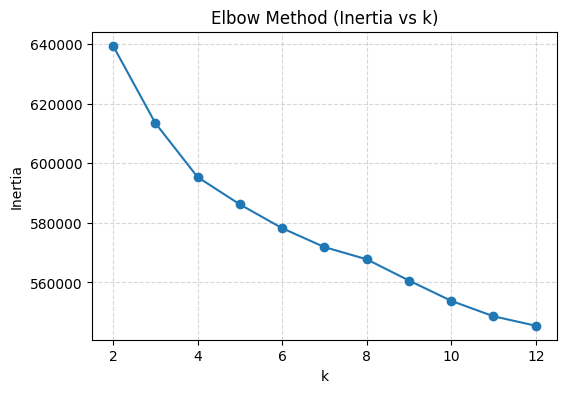

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

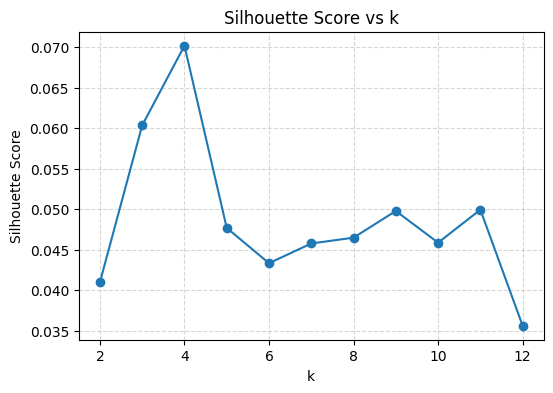

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
print(f"Selected best k (by silhouette): {best_k}")

Selected best k (by silhouette): 4


In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
train_clusters = kmeans.fit_predict(X_train)
test_clusters  = kmeans.predict(X_test)

In [ ]:
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca2 = pca2.fit_transform(X_train)

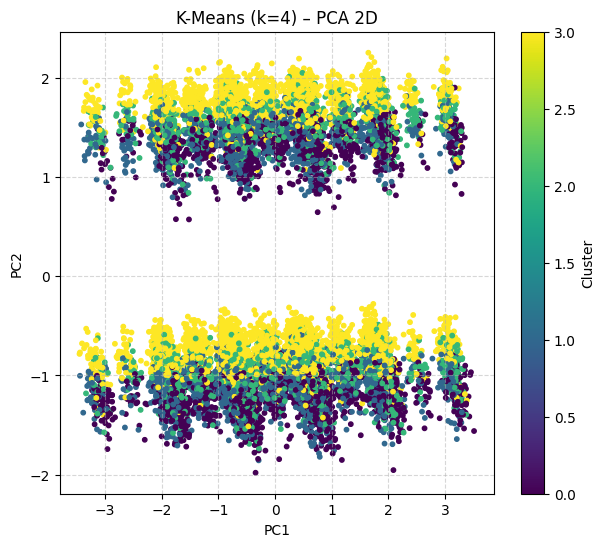

In [ ]:
plt.figure(figsize=(7,6))
scatter = plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=train_clusters, s=10)
plt.title(f"K-Means (k={best_k}) – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.colorbar(scatter, label="Cluster")
plt.show()

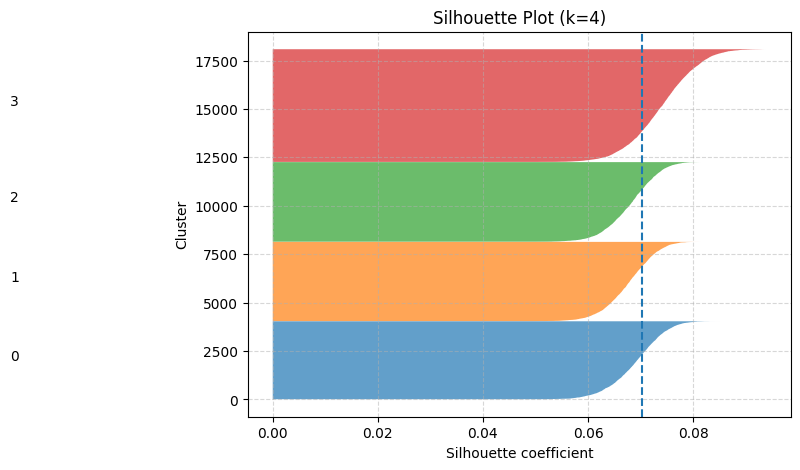

In [ ]:
sample_sil = silhouette_samples(X_train, train_clusters)
y_lower = 10
plt.figure(figsize=(7,5))
for i in range(best_k):
    ith_sil = sample_sil[train_clusters == i]
    ith_sil.sort()
    size_i = ith_sil.shape[0]
    y_upper = y_lower + size_i
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_sil, alpha=0.7
    )
    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=np.mean(sample_sil), linestyle="--")
plt.title(f"Silhouette Plot (k={best_k})")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
train_with_labels = train_X.copy()
train_with_labels["cluster"] = train_clusters
cluster_means = train_with_labels.groupby("cluster").mean()

In [ ]:
feat_var = cluster_means.var().sort_values(ascending=False)
top_feats = feat_var.index[:20].tolist()
print("Top-variance features across clusters:\n", top_feats)


Top-variance features across clusters:
 ['Blood test result_inconclusive', 'Blood test result_abnormal', 'Blood test result_normal', 'Blood test result_slightly abnormal', "Mother's age", "Father's age", 'Patient Age', 'Symptom Score', 'White Blood cell count (thousand per microliter)', 'Symptom 4', 'Parental Age Diff', 'History of anomalies in previous pregnancies', 'Birth defects', 'H/O radiation exposure (x-ray)', 'Symptom 3', 'Symptom 5', 'Symptom 1', 'Gender_female', 'Assisted conception IVF/ART', 'Gender_ambiguous']


In [ ]:
display_cols = top_feats + ["cluster"]
print("\nCluster means (top features):")
print(cluster_means[top_feats].round(3))


Cluster means (top features):
         Blood test result_inconclusive  Blood test result_abnormal  \
cluster                                                               
0                                   0.0                         1.0   
1                                   0.0                         0.0   
2                                   1.0                         0.0   
3                                   0.0                         0.0   

         Blood test result_normal  Blood test result_slightly abnormal  \
cluster                                                                  
0                             0.0                                  0.0   
1                             1.0                                  0.0   
2                             0.0                                  0.0   
3                             0.0                                  1.0   

         Mother's age  Father's age  Patient Age  Symptom Score  \
cluster                       

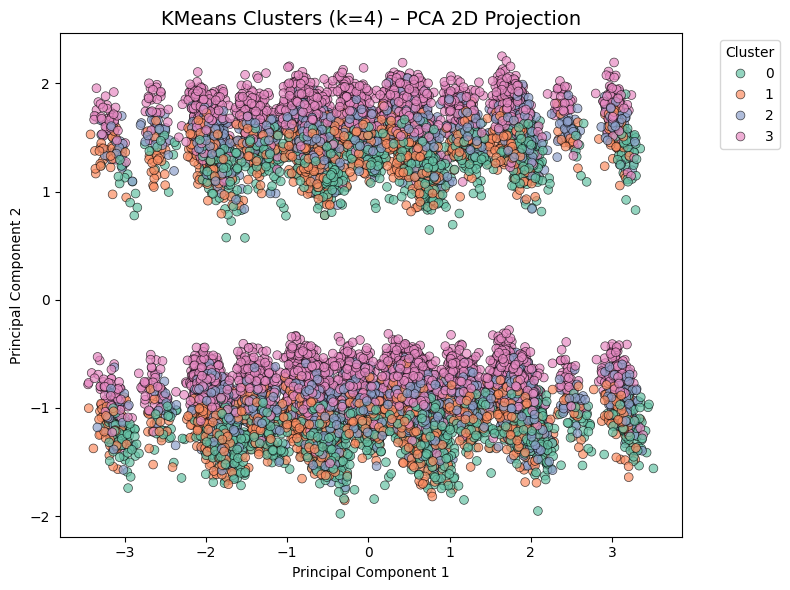

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_train_pca[:,0],
    y=X_train_pca[:,1],
    hue=train_clusters,
    palette="Set2",
    s=40, alpha=0.7, edgecolor="k"
)
plt.title(f"KMeans Clusters (k={best_k}) – PCA 2D Projection", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()